In [2]:
import time
import matplotlib
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio

import matplotlib.pyplot as plt
import numpy as np

# Enable interactive figures for latest versions of Jupyter Lab, with 'jupyter-matplotlib' 'widgetsnbextension' installed and activated.
#%matplotlib widget
# If no figure is showing, replace with
%matplotlib inline

In [3]:
# Time step of the data
dT = 0.05

Data_tensor = sio.loadmat('data/reaction_diffusion.mat')['Data_u']
Data_flat = Data_tensor.reshape((-1, Data_tensor.shape[2]), order='F')
X = Data_flat[:, 0:-1]
Xprime = Data_flat[:, 1:]

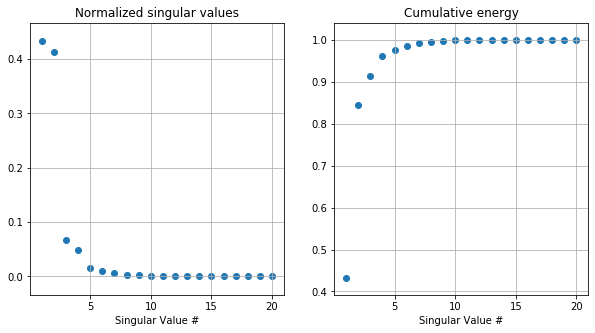

In [4]:
# Compute the SVD of the data
U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.T
S_norm = S / sum(S)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.grid()
ax1.set_title('Normalized singular values')
ax1.set_xlabel('Singular Value #')
ax1.scatter(range(1, 21), S_norm[0:20])

ax2.grid()
ax2.set_title('Cumulative energy')
ax2.set_xlabel('Singular Value #')
ax2.scatter(range(1, 21), np.cumsum(S_norm)[0:20])
plt.savefig('figs/RD_svd.png')

In [5]:
# Rank truncation at r=10
r = 10
Ur = U[:, 0:r]
Sigmar = np.diag(S[0:r])
Vr = V[:, 0:r]

In [6]:
# Reconstruct the data via truncated SVD
X_r = Ur @ Sigmar @ Vr.T.conj()
Data_r_tensor = X_r.reshape((512, 512, -1), order='F')

vmin = Data_flat.flatten().min()
vmax = Data_flat.flatten().max()

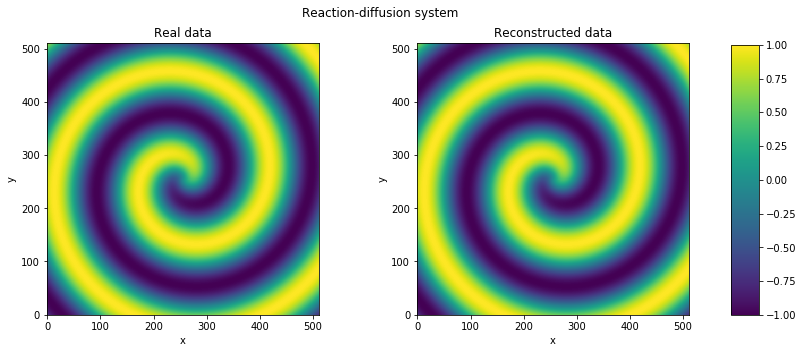

In [7]:
# Plot a comparison between the reconstructed data and the original data
# from IPython.display import HTML
# from matplotlib import rc

xx, yy = np.meshgrid(range(0, 512), range(0, 512))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Reaction-diffusion system')
map1 = ax1.imshow(Data_tensor[:, :, 0], vmin=vmin, vmax=vmax, origin='lower')
ax1.set_title('Real data')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
map2 = ax2.imshow(Data_r_tensor[:, :, 0], vmin=vmin, vmax=vmax, origin='lower')
ax2.set_title('Reconstructed data')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.125, 0.03, 0.75])
fig.colorbar(map2, cax=cbar_ax)


# function to update figure
def updatefig(j):
    fig.get_axes()[0].get_images()[0].set_data(Data_tensor[:, :, j])
    fig.get_axes()[1].get_images()[0].set_data(Data_r_tensor[:, :, j])
    return fig

# Save the animation as an MP4 file
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim = animation.FuncAnimation(fig, updatefig, frames=range(Data_tensor.shape[2]-1), interval=0.3, blit=False)

anim.save('RD_reconstruction.mp4', writer=writer)

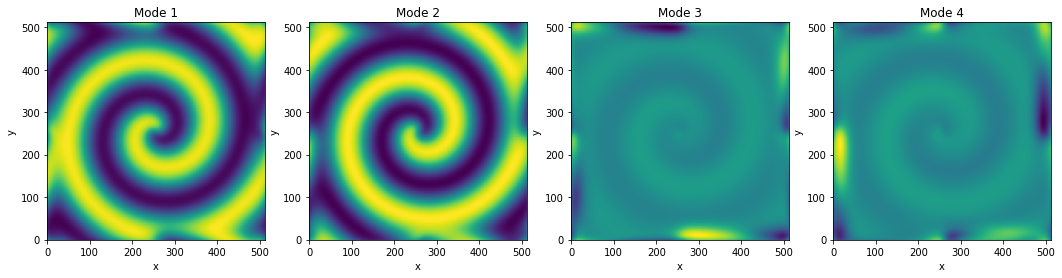

In [8]:
Modes_tensor = Ur[:, 0:4].reshape((512, 512, -1), order='F')
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for i in range(0, 4):
    mmap = axs[i].imshow(Modes_tensor[:, :, i], origin='lower')
    axs[i].set_title('Mode {}'.format(i+1))
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
plt.savefig('figs/RD_modes.png')

In [9]:
# DMD
A_tilde = Ur.conj().T @ Xprime @ Vr @ np.linalg.inv(Sigmar)

Lambda, W = np.linalg.eig(A_tilde)
Phi = Xprime @ Vr @ np.linalg.inv(Sigmar) @ W
omega = np.log(Lambda) / dT
B = np.linalg.pinv(Phi) @ X[:, 0]

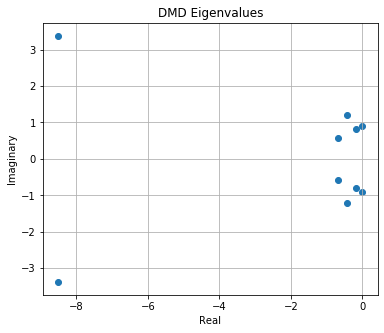

In [10]:
# Plot the eigenvalues
from sklearn.metrics import mean_squared_error

figx, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(np.real(omega), np.imag(omega))
ax.set_title('DMD Eigenvalues')
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
ax.grid()
plt.savefig('figs/RD_DMD_eigenvalues.png')

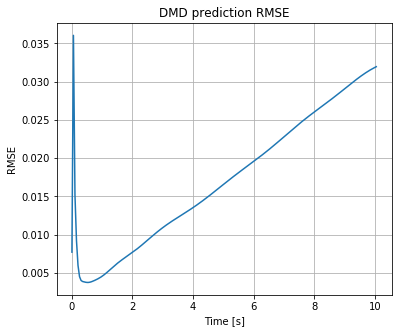

In [11]:
# Compute and plot the MSE
t = np.linspace(0, dT * Data_tensor.shape[2], Data_tensor.shape[2])

Data_pred_flat = np.real([sum([Phi[:, k] * np.exp(omega[k] * tau) * B[k] for k in range(0, B.shape[0])]) for tau in t]).T

MSE_flat = np.sqrt(np.square(Data_flat - Data_pred_flat).mean(axis=0))

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(t, MSE_flat)
ax.set_xlabel('Time [s]')
ax.set_ylabel('RMSE')
ax.set_title('DMD prediction RMSE')
ax.grid()
plt.savefig('figs/RD_DMD_RMSE.png')


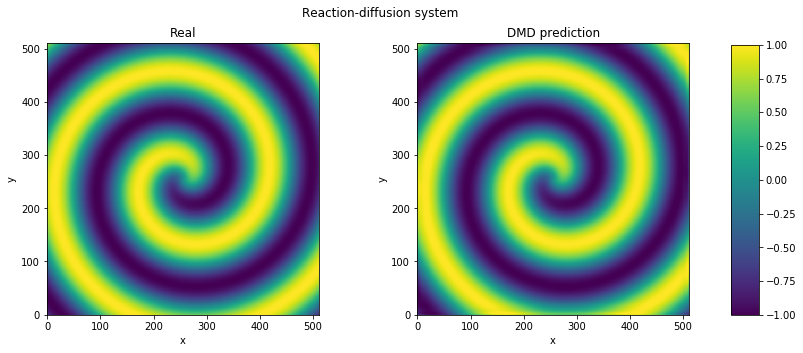

In [12]:
Data_predicted_tensor = Data_pred_flat.reshape((512, 512, -1), order='F')

xx, yy = np.meshgrid(range(0, 512), range(0, 512))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Reaction-diffusion system')
map1 = ax1.imshow(Data_tensor[:, :, 0], vmin=vmin, vmax=vmax, origin='lower')
ax1.set_title('Real')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
map2 = ax2.imshow(Data_predicted_tensor[:, :, 0], vmin=vmin, vmax=vmax, origin='lower')
ax2.set_title('DMD prediction')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.125, 0.03, 0.75])
fig.colorbar(map2, cax=cbar_ax)


# function to update figure
def updatefig2(j):
    fig.get_axes()[0].get_images()[0].set_data(Data_tensor[:, :, j])
    fig.get_axes()[1].get_images()[0].set_data(Data_predicted_tensor[:, :, j])
    return fig

# Save the animation as an MP4 file
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim2 = animation.FuncAnimation(fig, updatefig2, frames=range(Data_tensor.shape[2]-1), interval=0.3, blit=False)

anim2.save('RD_DMD_prediction.mp4', writer=writer)